In [ ]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import datasets
import pandas as pd
import io
import json
import csv
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/뱀장어 평균 중량인식 공모전/data/dataset')

train 폴더 124개의 각 평균면적 구하기

In [ ]:
# train 폴더목록 불러오기
folder_list = os.listdir('./train')
folder_list.sort()

#'한 영상 안에서의 뱀장어의 평균 중량' list
Area_list_video=[]
# train 폴더 내 json파일 목록 불러오기
for folder in folder_list:
  path = './train/' + folder
  train_folder_list = os.listdir(path)
  train_folder_list.sort()

  # json 파일만 불러오기
  json_file_list = [file for file in train_folder_list if file.endswith('.json')]

  dict = {}
  #'한 json파일 안의 뱀장어 n마리의 평균 중량' list
  Area_list_json=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list:
    with open((path + '/' + json_file),'r') as f:
      dict = json.load(f)
      #print(dict)

    #'한 json파일 안에서 선별된 뱀장어 각각의 중량' list
    Area_list_n = []
    for poly_num in range(len(dict['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict['data'][poly_num]['x']
      y_point = dict['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      area=PolyArea(x_point,y_point)
      Area_list_n.append(area)
    avg_area_n = sum(Area_list_n)/len(Area_list_n)
    Area_list_json.append(avg_area_n)
  avg_area_json = sum(Area_list_json)/len(Area_list_json)
  Area_list_video.append(avg_area_json)

In [ ]:
print(Area_list_video)
print(len(Area_list_video))

[1530.0917324117788, 1597.271297701618, 691.3977733148681, 751.3579362399257, 577.4320079431355, 1373.7333301219503, 722.257640719674, 642.4761908775639, 767.1684724861364, 1669.7131727600508, 653.0102271550023, 586.7270497479072, 1677.9273889562432, 1612.6329668181154, 575.3908651989371, 1634.9860768255119, 702.7979240439298, 555.293564216672, 751.0888617911639, 1419.2303985932288, 698.2575879704233, 755.1091718412142, 770.4037900941219, 1747.8408480866724, 1624.9219711434305, 1579.0697968779064, 1887.5133263192092, 800.8338644533775, 1328.9934600970912, 1669.1631794680068, 658.8348555452278, 648.2612531977002, 649.7642645181076, 671.5978727048457, 666.407881313552, 1247.9721791987943, 1337.7768267652675, 777.0840390625112, 689.1927808433122, 715.6707189431547, 1562.6593902670586, 603.247538688205, 1670.665606308423, 1543.41733223879, 731.865402410205, 549.2888564167177, 791.6558482433151, 587.5438656567045, 1668.3070420267907, 606.0141931537775, 748.0393862538499, 786.5446802197157, 

train 124개 폴더의 평균 중량값 얻기

In [ ]:
train_csv = pd.read_csv('./train.csv')
#train_csv 정렬
train_csv=train_csv.sort_values(by='ImageDir', ascending=True)

,ImageDir,AvgWeight
19,09xhTGOWvG,72.089286
117,1IfHWGbtMf,95.033696
8,2FINMdB8FA,27.564475
60,2ZUn5NjsOy,45.250000
110,2io6VOZw5l,21.020000


In [ ]:
#volumn and Weight (m=밀도,부피 곱)
volumn_list_video=[x**1.5 for x in Area_list_video]
np.corrcoef(volumn_list_video, AvgWeight)[0,1]

0.9162826347692218

Linear Regression model 적용하기

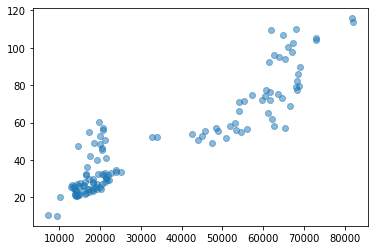

In [ ]:
Vol = torch.Tensor(volumn_list_video)
Weight = torch.Tensor(AvgWeight)
x_train = Vol  # X for model training
x_train = x_train.reshape(-1,1)
y_train = Weight   # y label

plt.scatter(x_train, y_train, alpha=0.5)

In [ ]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(x_train,y_train)

w1=lm.coef_
b=lm.intercept_

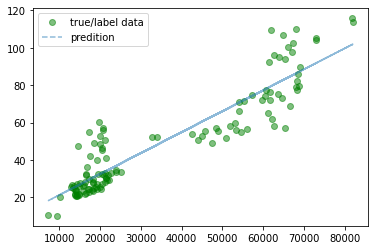

In [ ]:
y_fit = w1*volumn_list_video + b
plt.clf()
plt.plot(x_train, y_train, 'go', label='true/label data', alpha=0.5) 
plt.plot(x_train, y_fit, '--', label='predition', alpha=0.5)
plt.legend(loc='best')
plt.show()

train prediction csv생성

In [ ]:
train_predictions = lm.predict(x_train)

#주어진 train_csv의 ImageDir순서대로
folder_list_notsort = pd.read_csv('/content/drive/MyDrive/뱀장어 평균 중량인식 공모전/data/dataset/train.csv')

data = {'ImageDir':folder_list_notsort['ImageDir'], 'AvgWeight':train_predictions}
df = pd.DataFrame(data)
df

,ImageDir,AvgWeight
0,rWpm8pGP6m,77.417664
1,JNG5KEjmlh,81.158524
2,iEjH5UH1RS,30.715450
3,MbXDuCL1mH,34.054298
4,ckhBAXev60,24.369328
...,...,...
119,C84FL8SfWo,63.536469
120,ylOjt6o0Np,26.337654
121,usJWV06lBP,25.510250
122,Uvy7VSLDCD,30.720558


In [ ]:
csv_path = '/content/drive/MyDrive/뱀장어 연습/csv'
df.to_csv(csv_path+'/train_predict.csv',index = False)

x_test만들기

In [ ]:
# test 폴더목록 불러오기
folder_list_t = os.listdir('./test')
folder_list_t.sort()

#'한 영상 안에서의 뱀장어의 평균 중량' list
Area_list_video_t=[]
# test 폴더 내 json파일 목록 불러오기
for folder in folder_list_t:
  path = './test/' + folder
  test_folder_list = os.listdir(path)
  test_folder_list.sort()

  # json 파일만 불러오기
  json_file_list_t = [file for file in test_folder_list if file.endswith('.json')]

  dict_t = {}
  #'한 json파일 안의 뱀장어 n마리의 평균 중량' list
  Area_list_json_t=[]
  # json 파일의 폴리곤 데이터값을 dict로 불러오기
  for json_file in json_file_list_t:
    with open((path + '/' + json_file),'r') as f:
      dict_t = json.load(f)
      #print(dict)

    #'한 json파일 안에서 선별된 뱀장어 각각의 중량' list
    Area_list_n_t = []
    for poly_num in range(len(dict_t['data'])):
      # 폴리곤 좌표 이용하여 넓이 구하기
      x_point = dict_t['data'][poly_num]['x']
      y_point = dict_t['data'][poly_num]['y']

      def PolyArea(x_point,y_point):
        return 0.5*np.abs(np.dot(x_point,np.roll(y_point,1))-np.dot(y_point,np.roll(x_point,1)))

      area=PolyArea(x_point,y_point)
      Area_list_n_t.append(area)
    avg_area_n_t = sum(Area_list_n_t)/len(Area_list_n_t)
    Area_list_json_t.append(avg_area_n_t)
  avg_area_json_t = sum(Area_list_json_t)/len(Area_list_json_t)
  Area_list_video_t.append(avg_area_json_t)

In [ ]:
print(Area_list_video_t)
print(len(Area_list_video_t))

[662.4375370492812, 1708.7593173932387, 722.6720194970871, 663.7034483771207, 651.8044991189411, 568.8820669038878, 449.0646247493141, 1555.7210654514797, 726.4515932811953, 1618.9268529672943, 852.5906718135408, 1477.721343682583, 683.5192306434601, 1404.848888359753, 1342.6419857565306, 1724.0989784845353, 1799.156835956846, 1549.842560918113, 659.2050511774631, 648.6561225006251, 710.2440765257314, 703.7969545842535, 788.3841408263247, 1594.0854149255838, 725.183092149861, 742.4681457550467, 660.4892974873356, 1668.1238624589685, 1335.512175980922, 424.50283346379854, 398.9088482113063, 1981.4615247866811, 2017.282951770889, 672.1646101277685, 1629.9703960860122, 563.1109237578697, 1584.37277777866, 750.2532702290229, 1337.5697349176455, 619.4525751493973, 1565.5974483164375, 1067.356613563529, 779.2684541988293, 466.88742173619397, 1372.7004378427744, 750.4835997966347, 1435.9604387000663, 1714.457522921118, 1579.0697968779064, 1787.0966609367786, 609.4402469741007, 626.30569214866

In [ ]:
volumn_list_video_t=[x**1.5 for x in Area_list_video_t]

In [ ]:
Vol_t = torch.Tensor(volumn_list_video_t)
x_test = Vol_t  # X for model training
x_test = x_test.reshape(-1,1)

예측하기

In [ ]:
predictions = lm.predict(x_test)

csv파일 만들기

In [ ]:
folder_list_notsort = pd.read_csv('/content/drive/MyDrive/뱀장어/submission_sample.csv')
data = {'ImageDir':folder_list_notsort['ImageDir'], 'AvgWeight':predictions}
 
df = pd.DataFrame(data)
df

,ImageDir,AvgWeight
0,DBQDA1yGoy,29.148760
1,xSnT9ciFWW,89.175774
2,mrlUpGQsYr,31.812111
3,MXXkhMBpQC,29.203531
4,MijVDHVcap,28.690754
...,...,...
80,Io2LMFqcmM,29.630295
81,ckN3A3Edwq,38.163261
82,49UmJQBya0,86.055840
83,qhJ2pADf7o,85.141319


In [ ]:
csv_path = '/content/drive/MyDrive/뱀장어'
df.to_csv(csv_path+'/test.csv')